In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
writer = tf.summary.FileWriter('./')

In [46]:
num_iterations = 10000
num_neurons = 2

In [47]:
def fIs(v, vi):
    #Todo
    return

In [48]:
G_K = tf.constant(18.)
E_K = tf.constant(-80.)
G_Na = tf.constant(45.)
E_Na = tf.constant(55.)
Phi = tf.constant(4.)

def fINaK(v, h, n):    
    Alpha1 = -0.1*(v+33)/(tf.exp(-0.1*(v+33)) - 1)
    Beta1 = 4*(tf.exp(-1*(v +58)/12))
    m_inf = Alpha1/(Alpha1 + Beta1)
    
    Alpha2 = 0.07*tf.exp(-1*(v+50)/10)
    Beta2 = 1/(tf.exp(-0.1*(v+20)) + 1)
    tau_h = 1/(Alpha2 + Beta2)
    h_inf = Alpha2/(Alpha2 + Beta2)
    
    Alpha3 = -0.01*(v+34)/(tf.exp(-0.1*(v+34)) - 1);
    Beta3 = 0.125*tf.exp(-1*(v+44)/25);
    tau_n = 1/(Alpha3 + Beta3);
    n_inf = Alpha3/(Alpha3 + Beta3);

    fn = Phi*(n_inf - n)/tau_n
    fh = Phi*(h_inf - h)/tau_h
    
    INa = G_Na*m_inf*m_inf*m_inf*h*(v - E_Na);
    Ik = G_K*n*n*n*n*(v - E_K);
    
    return INa, Ik, fn, fh

In [49]:
ve = tf.constant(0.)
def fIl(v):
    return 0.1*(ve-v)

In [50]:
decay_constant = tf.constant(0.1)

def get_step_input(current_input, step_no):
    if step_no == 1:
        return current_input
    elif step_no > 1:
        return  decay_constant * current_input
    
def rk_step(v, step_input):
    return c*(ve-v) + step_input

In [51]:
def neuron_combined_steps(prev_state, ext_current):
    vi, v, n, h = prev_state
    
    rk_step_values = []
    step_input = ext_current
    
    for step in range(1, 5):
        INa, Ik, n, h = fINaK(v, n, h)
        Il = fIl(v)
        
        dv = INa + Ik + Il
        step_input = get_step_input(step_input, step)
        rk_step_val = rk_step(dv, step_input)
        
        rk_step_values.append(rk_step_val)
    
    vi_next = 1/6*(rk_step_values[0]+2*rk_step_values[1]+2*rk_step_values[2]+rk_step_values[3])
    
    return [vi_next, v, n, h]

In [52]:
# inputs to the neurons
inp = 0.05
inputs = tf.Variable(np.array([[inp] + [0.]*(num_neurons-1)] * num_iterations), dtype=tf.float32)

# initial activations and the combined input from synaptic connections
initial_val=20.0
vi_initial = tf.Variable(np.array([initial_val]*num_neurons), dtype=tf.float32)
v_initial = tf.Variable(np.array([0.]*num_neurons), dtype=tf.float32)
n_initial = tf.Variable(np.array([0.]*num_neurons), dtype=tf.float32)
h_initial = tf.Variable(np.array([0.]*num_neurons), dtype=tf.float32)

initial_state = [vi_initial, v_initial, n_initial, h_initial]

# recurrent execution. will iterate to the size of the inputs
out = tf.scan(neuron_combined_steps, inputs, initializer=initial_state)

In [53]:
%%time
# running the tensorflow graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)
    iteration_vals = sess.run(out)

CPU times: user 15.5 s, sys: 13.2 s, total: 28.7 s
Wall time: 16.4 s


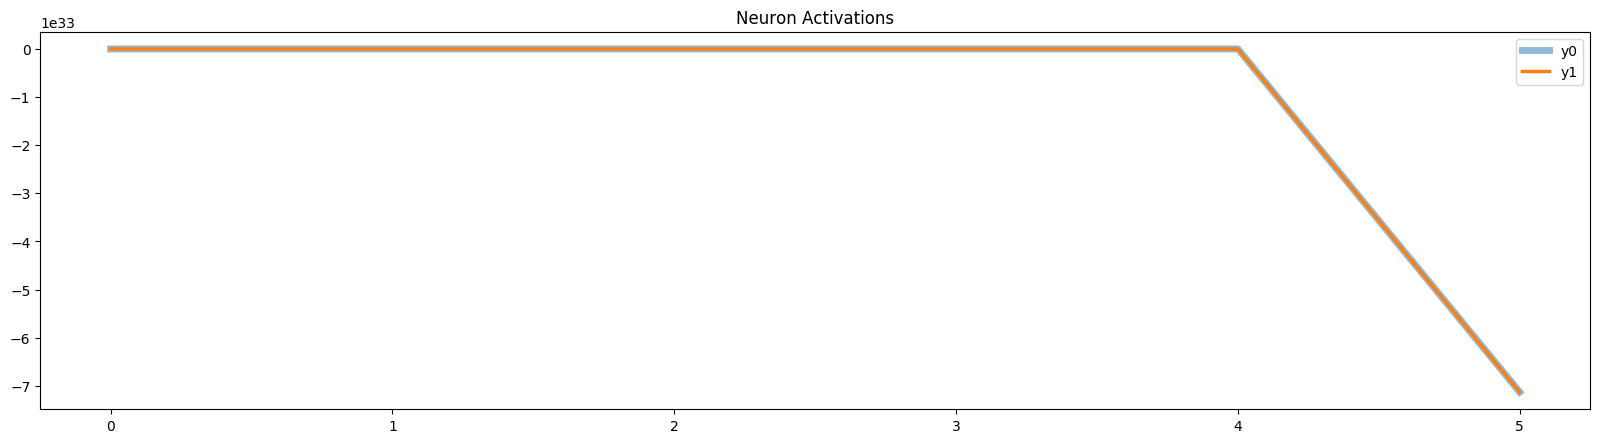

In [75]:
plt.figure(figsize=(20,5))
plt.title('Neuron Activations')
for i in range(num_neurons):
    plt.plot([y[i] for y in iteration_vals[0]], label='y'+str(i), alpha=(i+1.0)/(num_neurons),
             linewidth=5*(num_neurons-i)/(num_neurons))
plt.legend()
plt.show()